In [1]:
import os
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from blooddvh import CompartmentModel
from blooddvh import BloodDistribution
from blooddvh import tDVH
from blooddvh import bDVH

# Generate a transition matrix of body compartments for the blood particles to move between

In [2]:
steps_per_min = 60  # Number of steps per min, e.g., step resolutions are 1 sec and 0.1 sec for 60 and 600, respectively
model = CompartmentModel(os.path.join('..', 'input', 'ICRP89_compartment_model.xlsx'), 'male', vol=5.3, cardiac=6.5, resolution=steps_per_min)

# Create a blood distribution simulation from the body compartment model

In [3]:
blood_dist = BloodDistribution()
time_per_step = 1   # seconds
sample_size = 100   # the number of blood particles to simulate
blood_dist.generate_from_markov(model.markov, model.name, model.volume, time_per_step, sample_size, steps_per_min)

Time to generate blood distribution: 1.224727 seconds


# Simulate some dose fields

In [4]:
dose = tDVH()
# First 10 sec, 2 Gy uniform
dose.add(10, lambda x: 2)
# Next 10 sec, no dose
dose.add(10, None)
# Next 10 sec, 5 Gy uniform
dose.add(10, lambda x: 5)

# Apply the dose fields to some organs and graph the resulting bDVH

[(0, 'brain'), (1, 'thyroid'), (2, 'breast'), (3, 'lymph_nodes'), (4, 'large_veins'), (5, 'all_other'), (6, 'fat'), (7, 'skeletal_muscle'), (8, 'adrenals'), (9, 'skin'), (10, 'red_marrow'), (11, 'spongy_bone'), (12, 'compact_bone'), (13, 'other_skeleton'), (14, 'bronchial'), (15, 'pulmonary'), (16, 'right_heart'), (17, 'left_heart'), (18, 'coronary'), (19, 'liver'), (20, 'kidneys'), (21, 'bladder'), (22, 'gonads'), (23, 'aorta_large_arteries'), (24, 'pancreas'), (25, 'spleen'), (26, 'stomach_oesophagus'), (27, 'small_intestine'), (28, 'large_intestine')]


Text(0, 0.5, '# of Events')

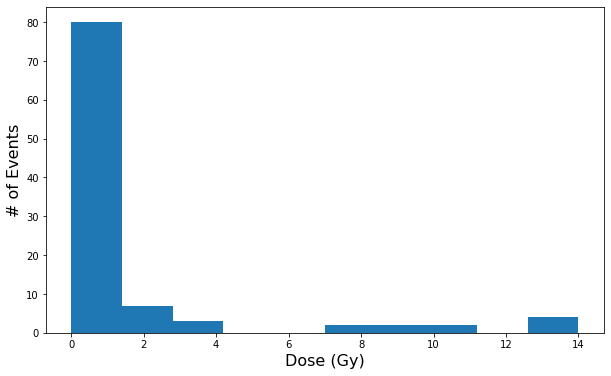

In [5]:
# To choose an organ where the dose is delivered
print(list(zip(range(len(model.name)), model.name)))
blood_dose = bDVH(blood_dist.df, blood_dist.dt)
# Add dose to Liver
blood_dose.add_dose(dose, 19, start_time=0)
blood_dose.add_dose(dose, 19, start_time=4)
# Add dose to Brain
blood_dose.add_dose(dose, 0, start_time=0)
# Draw your blood DVH (differential)
plt.figure(figsize=(10,6))
plt.hist(blood_dose.dose)
plt.xlabel('Dose (Gy)', fontsize=16)
plt.ylabel('# of Events', fontsize=16)

# Save the blood distribution to an Excel sheet

In [7]:
blood_dist.save('test_BP_path.xlsx', 'test')

# Let's do an example from extracted DVHs

In [8]:
# Read the DVH
DVH_FILE_PATH = 'test_dvh.csv'
df = pd.read_csv(DVH_FILE_PATH, skiprows=0)
dose_bins = np.array(df.iloc[:,0])
organs = df.columns[1:].tolist()

# Create the BP distribution and read in a pre-generated output
BP = BloodDistribution()
BP.read_from_excel(
    f_name='test_BP_path.xlsx', # 'test_male.xlsx',
    t_name='test'               # 'test_100k_10min_w2_cv'
)

# Set the initial fractionation and dosing
N_FRACTIONS = 15
dose_per_fraction = ((1/N_FRACTIONS) * dose_bins).tolist()

# Calculate bDVH per courses
blood_dose = bDVH(BP.df, BP.dt)

# Per-DVH
comp_dose = []
comp_id = []
for i,c in enumerate(organs):
    vol = np.array(df.iloc[:,i+1])
    dvh_combined = np.vstack((dose_per_fraction, vol)).transpose()
    # Get the compartment ID
    cid = BP.names.index(c)
    # Create a beam
    beam = tDVH()
    beam_on_time = 60   # s
    beam.add_array(beam_on_time, dvh_combined)
    # Append the beam dose and compartment ID to composite
    comp_dose.append(beam)
    comp_id.append(cid)

# Apply course
blood_dose.add_dose(comp_dose, comp_id, 0, N_FRACTIONS)

# Print the results
d0 = blood_dose.volume_gt_dose(0)
d1 = blood_dose.volume_gt_dose(0.5)
d2 = blood_dose.volume_gt_dose(1.0)
d3 = blood_dose.volume_gt_dose(2.0)
v0 = blood_dose.dose_at_top_volume(2.0)
v1 = blood_dose.dose_at_top_volume(3.0)
output_columns=['V0', 'V0_Dmean', 'V0_Dstd',
                'V0.5', 'V0.5_Dmean', 'V0.5_Dstd',
                'V1.0', 'V1.0_Dmean', 'V1.0_Dstd',
                'V2.0', 'V2.0_Dmean', 'V2.0_Dstd',
                'D2%', 'D2%_Dmean', 'D2%_Dstd',
                'D3%', 'D3%_Dmean', 'D3%_Dstd']
output_data = [d0[0], d0[1], d0[2],
               d1[0], d1[1], d1[2],
               d2[0], d2[1], d2[2],
               d3[0], d3[1], d3[2],
               v0[0], v0[1], v0[2],
               v1[0], v1[1], v1[2]]
print(list(zip(output_columns, output_data)))

test.bin
[('V0', 100.0), ('V0_Dmean', 6.0577150054107936), ('V0_Dstd', 1.1403569464828207), ('V0.5', 100.0), ('V0.5_Dmean', 6.0577150054107936), ('V0.5_Dstd', 1.1403569464828207), ('V1.0', 100.0), ('V1.0_Dmean', 6.0577150054107936), ('V1.0_Dstd', 1.1403569464828207), ('V2.0', 100.0), ('V2.0_Dmean', 6.0577150054107936), ('V2.0_Dstd', 1.1403569464828207), ('D2%', 8.553022969933128), ('D2%_Dmean', 8.726898615490201), ('D2%_Dstd', 0.17387564555707336), ('D3%', 8.526402737651999), ('D3%_Dmean', 8.6600666562108), ('D3%_Dstd', 0.17055257735032803)]
